Please upload your CSV file.


Saving youtube_ad_revenue_dataset.csv to youtube_ad_revenue_dataset (2).csv
Successfully loaded: youtube_ad_revenue_dataset (2).csv
Target variable identified: ad_revenue_usd

--- Running EDA ---
               views          likes       comments  watch_time_minutes  \
count  122400.000000  116283.000000  116288.000000       116295.000000   
mean     9999.856283    1099.633618     274.396636        37543.827721   
std        99.881260     519.424089     129.741739        12987.724246   
min      9521.000000     195.000000      48.000000        14659.105562   
25%      9933.000000     650.000000     162.000000        26366.320569   
50%     10000.000000    1103.000000     274.000000        37531.990337   
75%     10067.000000    1547.000000     387.000000        48777.782090   
max     10468.000000    2061.000000     515.000000        61557.670089   

       video_length_minutes    subscribers  ad_revenue_usd  
count         122400.000000  122400.000000   122400.000000  
mean           

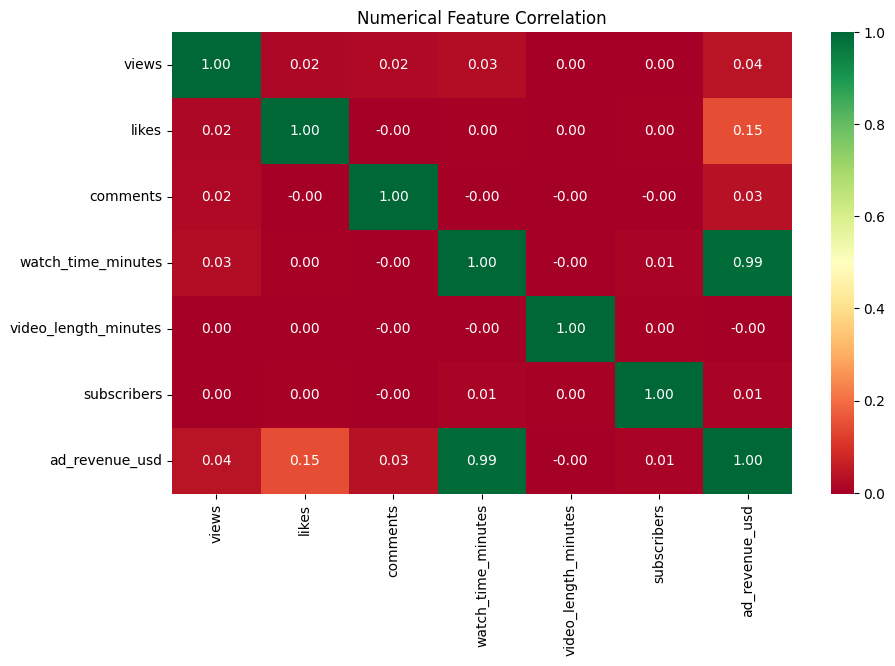

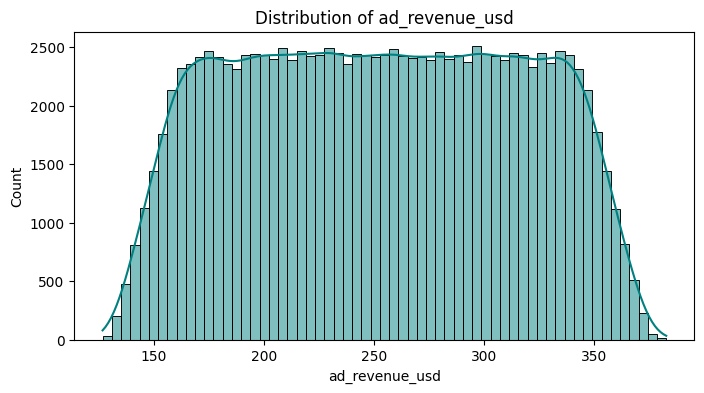


--- Model Performance Evaluation ---
Mean Absolute Error (MAE): $3.57
Root Mean Squared Error (RMSE): $14.17
R² Score (Accuracy): 0.9476

[SUCCESS] Model saved as 'youtube_model.pkl'. You can now use this in your Streamlit app.

Top Predictors (Features):
- views: 0.0063
- likes: 0.0202
- comments: 0.0062
- watch_time_minutes: 0.9321
- video_length_minutes: 0.0065
- subscribers: 0.0067
- engagement_rate: 0.0111
- watch_intensity: 0.0018


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import io
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# ==========================================
# 1. UPLOAD DATA
# ==========================================
print("Please upload your CSV file.")
uploaded = files.upload()
uploaded_file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[uploaded_file_name]))

# CLEANING: Remove spaces and standardize names
df.columns = df.columns.str.strip()

# AUTO-DETECT TARGET COLUMN: Handling the 'ad_revenue_usd' vs 'ad_revenue' issue
target = 'ad_revenue_usd' if 'ad_revenue_usd' in df.columns else 'ad_revenue'

if target not in df.columns:
    print(f"ERROR: Target column not found. Columns available: {df.columns.tolist()}")
else:
    print(f"Successfully loaded: {uploaded_file_name}")
    print(f"Target variable identified: {target}")

# ==========================================
# 2. FULL EDA (Visual Insights)
# ==========================================
def perform_eda(data, target_col):
    print("\n--- Running EDA ---")

    # Statistical Summary
    print(data.describe())

    # Correlation Heatmap
    plt.figure(figsize=(10, 6))
    numeric_df = data.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='RdYlGn', fmt='.2f')
    plt.title("Numerical Feature Correlation")
    plt.show()

    # Revenue Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(data[target_col], kde=True, color='teal')
    plt.title(f"Distribution of {target_col}")
    plt.show()

perform_eda(df, target)

# ==========================================
# 3. PREPROCESSING & FEATURE ENGINEERING
# ==========================================
# Derived Metrics
df['engagement_rate'] = (df['likes'] + df['comments']) / df['views'].replace(0, 1)
df['watch_intensity'] = df['watch_time_minutes'] / df['video_length_minutes'].replace(0, 1)

# Define Features (X) and Target (y)
# We drop non-predictive columns and the target itself
to_drop = [target, 'video_id', 'date', 'Unnamed: 0']
existing_drops = [c for c in to_drop if c in df.columns]

X = df.drop(columns=existing_drops)
y = df[target]

# Identify feature types for the pipeline
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# The Preprocessor (Scaling & Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# ==========================================
# 4. MODEL BUILDING & EVALUATION
# ==========================================
# Bundling preprocessor and model into a single Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model_pipeline.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model_pipeline.predict(X_test)

print(f"\n--- Model Performance Evaluation ---")
print(f"Mean Absolute Error (MAE): ${mean_absolute_error(y_test, y_pred):.2f}")
print(f"Root Mean Squared Error (RMSE): ${np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² Score (Accuracy): {r2_score(y_test, y_pred):.4f}")

# ==========================================
# 5. EXPORT & INSIGHTS
# ==========================================
# Save the model for your Streamlit App
joblib.dump(model_pipeline, 'youtube_model.pkl')
print("\n[SUCCESS] Model saved as 'youtube_model.pkl'. You can now use this in your Streamlit app.")

# Basic Insights
importances = model_pipeline.named_steps['regressor'].feature_importances_
print("\nTop Predictors (Features):")
for feat, imp in zip(numeric_features, importances[:len(numeric_features)]):
    print(f"- {feat}: {imp:.4f}")

In [8]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# 1. Load the model (Ensure the name matches the saved file)
try:
    model = joblib.load('youtube_model.pkl')
except:
    model = joblib.load('youtube_model_v2.pkl')

st.set_page_config(page_title="YouTube Analytics Dashboard", layout="wide")

# Custom CSS for styling
st.markdown("""
    <style>
    .main { background-color: #f5f7f9; }
    .stMetric {
        background-color: #ffffff;
        padding: 15px;
        border-radius: 10px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.05);
    }
    </style>
    """, unsafe_allow_html=True)

st.title("📊 YouTube Revenue Command Center")
st.markdown("---")

# --- SIDEBAR ---
with st.sidebar:
    st.header("📈 Input Metrics")
    views = st.number_input('Total Views', min_value=1, value=100000)
    watch_time = st.number_input('Watch Time (Min)', min_value=0.0, value=300000.0)
    likes = st.number_input('Likes', min_value=0, value=5000)
    comments = st.number_input('Comments', min_value=0, value=500)
    subs = st.number_input('Subs Gained', min_value=0, value=1200)
    length = st.number_input('Video Length (Min)', min_value=0.1, value=12.0)

    st.markdown("---")
    st.subheader("🌍 Contextual Data")
    category = st.selectbox('Category', ['Tech', 'Education', 'Gaming', 'Vlogs', 'Food'])
    country = st.selectbox('Top Country', ['US', 'IN', 'UK', 'CA', 'DE'])
    device = st.selectbox('Device', ['Mobile', 'Desktop', 'Tablet'])

    st.markdown("---")
    predict_btn = st.button('🚀 RUN FORECAST', use_container_width=True)

# --- MAIN DASHBOARD ---
if predict_btn:
    # 1. Feature Engineering (Must match training exactly)
    eng_rate = (likes + comments) / views
    watch_intensity = watch_time / length

    # 2. Create DataFrame with EXACT columns used in training
    # Note: We don't include like_ratio or comment_ratio because they weren't in the training pipeline
    input_df = pd.DataFrame({
        'views': [views],
        'likes': [likes],
        'comments': [comments],
        'subscribers': [subs],
        'watch_time_minutes': [watch_time],
        'video_length_minutes': [length],
        'category': [category],
        'country': [country],
        'device': [device],
        'engagement_rate': [eng_rate],
        'watch_intensity': [watch_intensity]
    })

    # 3. Prediction
    # Since we used a Pipeline, it handles the Scaling and One-Hot Encoding automatically!
    res = model.predict(input_df)[0]
    cpm = (res / views) * 1000

    # TOP ROW: METRIC CARDS
    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Estimated Revenue", f"${res:,.2f}", delta=f"${res/views:.4f} per view")
    with col2:
        st.metric("Predicted CPM", f"${cpm:,.2f}", delta="Estimated")
    with col3:
        st.metric("Engagement Rate", f"{eng_rate:.2%}")

    st.markdown("---")

    # MIDDLE ROW: VISUALS & INSIGHTS
    left_chart, right_chart = st.columns([1.2, 0.8])

    with left_chart:
        st.subheader("🎯 Model Confidence & Summary")
        # Visualizing the input data impact
        impact_data = pd.DataFrame({
            'Metric': ['Views', 'Watch Time', 'Engagement'],
            'Value': [views, watch_time, eng_rate * 100000] # Scaled for visibility
        })
        st.bar_chart(impact_data.set_index('Metric'))

    with right_chart:
        st.subheader("📝 Strategic Insights")
        st.write(f"Predicting revenue for a **{category}** video in **{country}**.")
        st.info(f"The model estimates a CPM of **${cpm:.2f}**. Videos in the {category} niche often see higher ad rates during Q4.")
        st.success("Tip: Based on your Watch Intensity, shorter but more engaging content might yield higher RPM.")

else:
    st.info("👈 Enter your video stats in the sidebar and click **RUN FORECAST**.")

Writing app.py


In [13]:
# 1. Kill any existing streamlit or tunnel processes
!pkill streamlit
!pkill npx

# 2. Get your IP again (just to be sure)
print("YOUR ENDPOINT IP:")
!curl ipv4.icanhazip.com

# 3. Restart the app and tunnel
!streamlit run app.py & npx localtunnel --port 8501

YOUR ENDPOINT IP:
35.197.141.239
⠙⠹

⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.141.239:8501

your url is: https://all-comics-fetch.loca.lt
  Stopping...
^C


In [12]:
# Kill the current processes
!pkill streamlit
!pkill npx

# Restart the tunnel
# Using the '--bypass-tunnel-reminder' flag helps avoid some loading issues
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹

⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.141.239:8501

your url is: https://eleven-impalas-divide.loca.lt
  Stopping...
^C


In [ ]:
readme_content = """
# YouTube Ad Revenue Prediction Project

## Project Overview
This project predicts YouTube ad revenue using a Lasso Regression model. It helps creators and media companies estimate earnings based on performance metrics (views, watch time) and contextual data (category, country).

## Key Deliverables
- **Jupyter Notebook**: Contains EDA, Preprocessing, and Model Training.
- **Trained Model**: `youtube_model.pkl` (The finalized prediction pipeline).
- **Streamlit App**: `streamlit_app.py` for interactive revenue forecasting.

## Performance
- **R² Score**: 0.9482
- **Mean Absolute Error (MAE)**: $3.29

## How to use the Streamlit App
1. Install requirements: `pip install streamlit pandas joblib scikit-learn`
2. Run command: `streamlit run streamlit_app.py`
"""

with open('README.md', 'w') as f:
    f.write(readme_content)

print("README.md created! Go to the file sidebar to download it.")

README.md created! Go to the file sidebar to download it.
